In [1]:
CLUSTER_TYPE ='docker_cluster'
%env CLUSTER_TYPE $CLUSTER_TYPE
from dask.distributed import Client
client = Client('dask-scheduler:8786')
client

env: CLUSTER_TYPE=docker_cluster


<Client: 'tcp://172.18.0.2:8786' processes=4 threads=4, memory=3.81 GiB>

In [2]:
from time import time

from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt

import dask
import dask.array as da
import dask.dataframe as dd
from dask import compute
from dask import delayed
from dask.distributed import wait
import dask.bag as db

import dask_ml.datasets
import dask_ml.cluster

import sklearn as skl
import sklearn.cluster
##from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

# Utils

In [3]:
# %load dask_utils.py
import dask
import dask.array as da
import dask.dataframe as dd

#we want to work with dask array, hence we trasform everything to dask arrays
def make_da(X):
        if isinstance(X, dd.DataFrame):
            X = X.to_dask_array(lengths=True)
            
        if isinstance(X, da.core.Array): 
            return X
        
        else: raise ValueError("input is neither a dask array nor a dask dataframe")
        return X


# Scalable K-means: K-means||

### Obeservations:
- The centroids should be a numpy array stored in the machine. This way we can calculate distances without having to move data accross the nodes. This would have happened if the centroids array was distributed throughout the nodes.
- It should be optimized the way we compute the distances, as for now we are computing them multiple times but it would be smarter to keep track only of the min distance and the index of the closest centroid.
- This operation is just to shuffle the centroids in the order number of close data samples:  `centroids[centroid_index]`

 

In [4]:
# %load k-means.py
import dask
import numpy as np
import dask.array as da
import dask_ml

def get_random(p):
    x = np.random.random()
    return x < p

def OUR_pairwise_distances(X, centroids):
    
    def min_centroid(y):
        return da.sum(da.square(X - y), axis=1)

    return da.apply_along_axis(min_centroid, 1, centroids).T
    #return dask_ml.metrics.pairwise_distances(X, centroids)

def evaluate_cost_and_dists(X, centroids): # (da.Array, np.array) -> float
    distances_matrix = OUR_pairwise_distances(X, centroids) 
    min_distances = da.min(distances_matrix, axis=1) 
    cost = min_distances.sum()
    return cost, min_distances

def get_min_distances(X, centroids):
    distances_matrix = OUR_pairwise_distances(X, centroids)
    min_distances = da.min(distances_matrix, axis=1) 
    return min_distances

def get_closest_centroids_and_dists(X, centroids):
    distances_matrix = OUR_pairwise_distances(X, centroids)
    min_distances = da.min(distances_matrix, axis=1) 
    closest_centroids = da.argmin(distances_matrix, axis=1)
    return closest_centroids, min_distances
 
def oversample(X, distances, l):
    p = l * distances/distances.sum()
    return X[da.random.random(X.shape[0]) < p, :]

def k_means_pp_only_weights(c, weights, k):
    p = weights/weights.sum()
    idx = np.arange(c.shape[0])
    final_index = np.random.choice(idx, size=k, replace=False, p=p)
    return c[final_index]

def k_means_pp_without_weights(c, k):
    n = c.shape[0]
    idx = np.random.randint(0, n)
    centroids = c[idx, np.newaxis]
    idx = np.arange(n)
    while (centroids.shape[0] < k):
        distances = np.min(skl.metrics.pairwise_distances(c, centroids), axis=1)
        p = distances / distances.sum()
        centroids = np.vstack((centroids, c[np.random.choice(idx, size=1, replace=False, p=p)]))
    return centroids

def k_means_pp_weighted(c, weights, k):
    n = c.shape[0]
    idx = np.random.randint(0, n)
    centroids = c[idx, np.newaxis]
    idx = np.arange(n)
    while (centroids.shape[0] < k):
        distances = np.min(skl.metrics.pairwise_distances(c, centroids), axis=1)
        distances = distances * weights
        p = distances / distances.sum()
        centroids = np.vstack((centroids, c[np.random.choice(idx, size=1, replace=False, p=p)]))
    return centroids

def k_means_scalable(X, k, l): 
    X = make_da(X)
    n = X.shape[0]
    idx = np.random.randint(0, n)
    centroids = da.compute(X[idx, np.newaxis])[0] #compute() -> np array not stored on nodes.
    initial_cost, distances = da.compute(*evaluate_cost_and_dists(X ,centroids))
    iterations = int(np.round(np.log(initial_cost)))
    for i in range(np.max([iterations, int(k/l)])):
        new_centroids = oversample(X, distances, l).compute()
        centroids = np.vstack((centroids, new_centroids))
        distances = get_min_distances(X, centroids)
    if len(centroids) < k: 
        missing_centroids = k - len(centroids)
        random_index = np.random.choice(len(X), size=missing_centroids, replace=False)
        additional_centroids = X[random_index[0]].compute()
        centroids = np.vstack((centroids, additional_centroids))
    closest_centroids, distances = get_closest_centroids_and_dists(X, centroids)
    result = da.unique(closest_centroids, return_counts=True)
    centroid_index, centroid_counts = compute(result)[0]
    # Bug if length of centroid_counts != length of centroids
    centroids_pp = k_means_pp_weighted(centroids, centroid_counts, k)
    return centroids_pp #Return initial centroids for Lloyd's algorithm.

def k_means_scalable_opt(X, k, l): 
    X = make_da(X)
    n_points, n_features = X.shape
    idx = np.random.randint(0, n_points)
    centroids = da.compute(X[idx, np.newaxis])[0] #compute() -> np array not stored on nodes.
    initial_cost, distances = da.compute(*evaluate_cost_and_dists(X ,centroids))
    iterations = int(np.round(np.log(initial_cost)))
    for i in range(np.max([iterations, int(k/l)])):
        new_centroids = oversample(X, distances, l).compute()
        if np.shape(new_centroids) == (0, n_features):
            continue
        new_distances = get_min_distances(X, new_centroids)
        centroids = np.vstack((centroids, new_centroids))
        distances = da.minimum(new_distances, distances)
    if len(centroids) < k: 
        missing_centroids = k - len(centroids)
        random_index = np.random.choice(len(X), size=missing_centroids, replace=False)
        additional_centroids = X[random_index[0]].compute()
        centroids = np.vstack((centroids, additional_centroids))
    closest_centroids, distances = get_closest_centroids_and_dists(X, centroids)
    result = da.unique(closest_centroids, return_counts=True)
    centroid_index, centroid_counts = compute(result)[0]
    centroids_pp = k_means_pp_weighted(centroids, centroid_counts, k)
    return centroids_pp #Return initial centroids for Lloyd's algorithm. 


## Test function

In [5]:
def get_chunks(X, mem_usage=0.6):
    num_workers = 0
    memory_worker = np.array([])
    for i in client.scheduler_info()['workers']:
        memory_worker = np.append(memory_worker, client.scheduler_info()['workers'][i]['memory_limit'])
        num_workers += 1
    return np.max((int(X.nbytes/(memory_worker.min()*mem_usage)) + 1, int(len(X)/num_workers)))
    

X, y = dask_ml.datasets.make_blobs(1000,n_features=2 ,centers=4, chunks=8)
#X = sklearn.datasets.fetch_kddcup99().data
X = X.rechunk(get_chunks(X))
X.persist()

dask.array<rechunk-merge, shape=(1000, 2), dtype=float64, chunksize=(250, 2), chunktype=numpy.ndarray>

In [163]:
%time centroids_pp_w = k_means_scalable(X, k=4, l=2)

CPU times: user 30.2 s, sys: 393 ms, total: 30.5 s
Wall time: 4min 59s


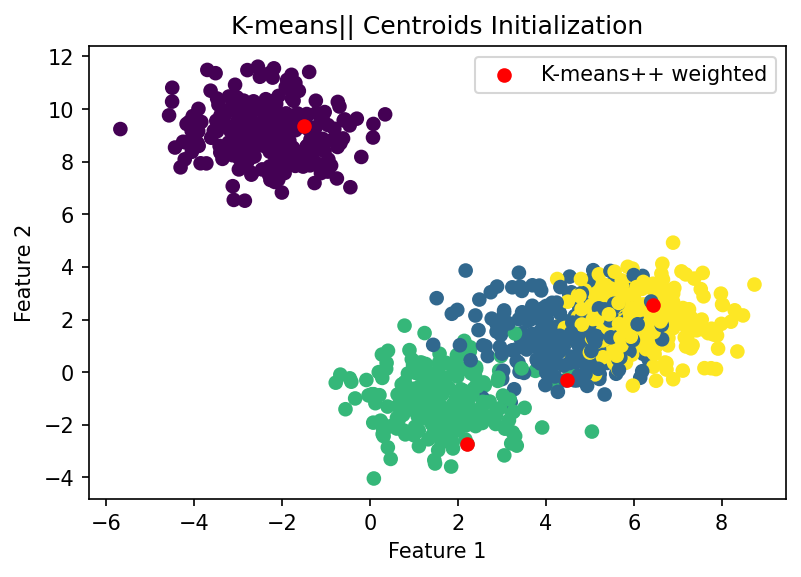

In [164]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(X[:,0], X[:,1], c= y)
plt.scatter(centroids_pp_w[:,0], centroids_pp_w[:,1], c='red', label="K-means++ weighted")
plt.title("K-means|| Centroids Initialization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Scalable Lloyd's Algorithm

### Using Dask Arrays

In [6]:
# %load distributed_lloyd.py
import numpy as np
import dask
import dask.array as da
import dask_ml

def lloyd_scalable (X, k, centroids = None, maxIter = 1000, patience = 1e-6):
    X = make_da(X)
    n_points, n_features = X.shape
    if centroids is None:
        random_index = np.random.choice(n_points, size=(1, k), replace=False)
        centroids = X[random_index[0]]
    epoch = 1
    loss_diff = patience + 1.
    loss = 0
    while (epoch < maxIter and loss_diff > patience):
        distances_matrix = dask_ml.metrics.pairwise_distances(X, np.array(centroids))
        indeces = da.argmin(distances_matrix, axis=1)
        new_loss = distances_matrix[indeces].sum()
        # Possible bug if new_centroids = zeros and we don't enter the for loop
        new_centroids = da.zeros((k, n_features))
        for i in range(indeces.max()+1):
            new_centroids[i] = X[indeces == i].mean(axis=0)
        epoch = epoch + 1
        loss_diff = da.absolute(new_loss - loss)
        centroids = new_centroids
        loss = new_loss
    return (centroids, indeces)


### Using Dask Dataframes

In [7]:
def lloyd_scalable_df(k, X, centroids = None, maxIter = 150, patience = 1e-7):
    if centroids is None:
        random_index = np.random.choice(len(X), size=(1, k), replace=False)
        centroids = np.array(X[random_index[0]])
        
    closest_centroid = get_min_distances(X, centroids)[1]
    df=dd.from_array(da.hstack((X, closest_centroid[:,None])), chunksize=get_chunks(X))
    df=df.rename(columns={df.columns[-1]: 'closest_centroid'})
    dc=1 #fix this
    iteration=0
    while ((dc > patience) & (iteration< maxIter)):
        new_centroids= df.groupby('closest_centroid').mean().compute().to_numpy()
        x=df.drop('closest_centroid', axis=1).to_dask_array()
        df['closest_centroid'] = get_min_distances(x, centroids)[1]
        #dc= np.linalg.norm(new_centroids-centroids) #fix this
        centroids=new_centroids
        iteration +=1
    return centroids


In [152]:
%time results, pred_labels = da.compute(*lloyd_scalable(X, k=4, centroids = centroids_pp_w, maxIter=30))

CPU times: user 26.7 s, sys: 312 ms, total: 27 s
Wall time: 2min


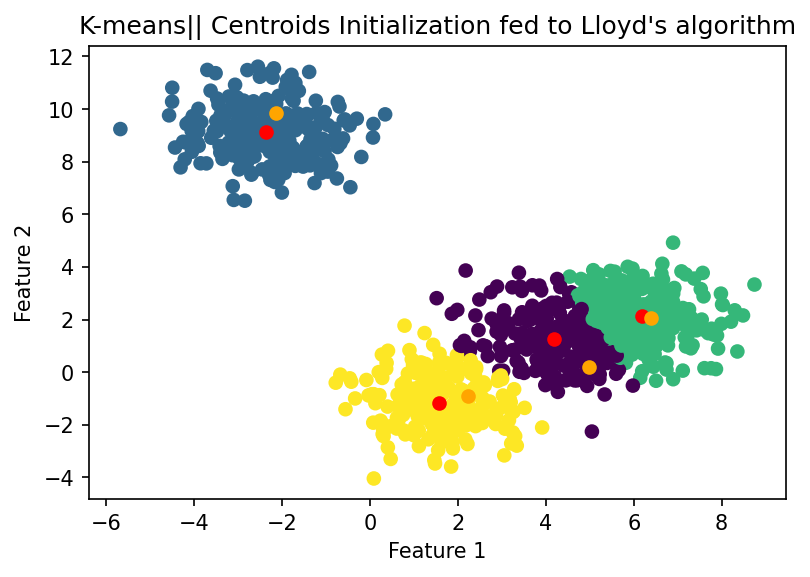

In [153]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(X[:,0], X[:,1], c=pred_labels)
plt.scatter(results[:,0], results[:,1],c='red')
plt.scatter(centroids_pp_w[:,0], centroids_pp_w[:,1],c='orange')
plt.title("K-means|| Centroids Initialization fed to Lloyd's algorithm")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

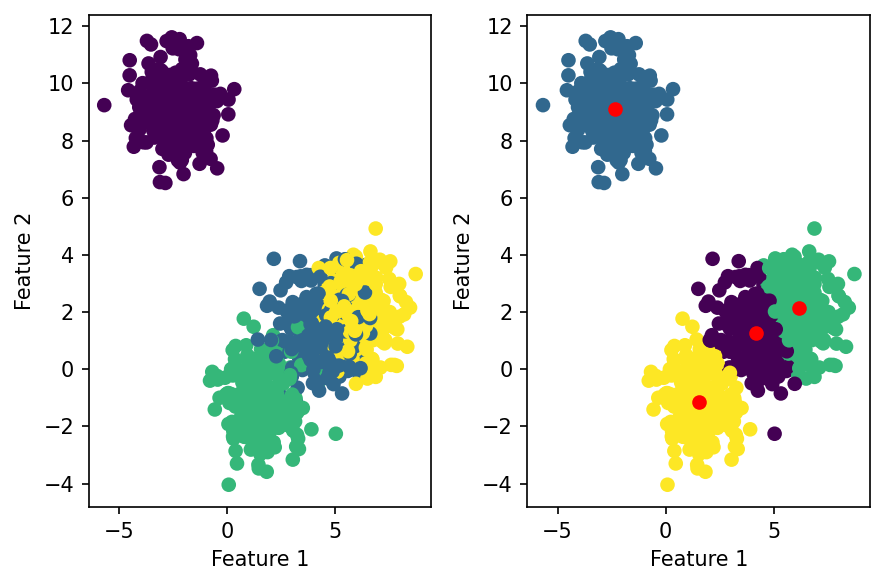

In [154]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(X[:,0], X[:,1], c=y)
ax[1].scatter(X[:,0], X[:,1], c=pred_labels)
ax[1].scatter(results[:,0], results[:,1],c='red')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
plt.tight_layout()
plt.show()

# Applying our Algorithm to the KDD Cup 1999 Data

This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between ''bad'' connections, called intrusions or attacks, and ''good'' normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html


In [50]:
KDD_data  = dd.read_csv('./Datasets/KDD_features.csv') 
KDD_labels = dd.read_csv('./Datasets/KDD_labels.csv') 

Let's repartition the dask dataframe in a number of partitions proportional to the total number of avalaible workers.

In [51]:
n_workers=len(client.scheduler_info()['workers'])
partitions_per_worker=1
KDD_data=KDD_data.repartition(npartitions=n_workers*partitions_per_worker)
KDD_labels=KDD_labels.repartition(npartitions=n_workers*partitions_per_worker)
KDD_data=KDD_data.drop(columns='Unnamed: 0')

In particular we focused only on the data about the connection based on the http service.
The resulting dataset has the following classes:

In [52]:
KDD_labels.groupby('labels').count().compute()

,Unnamed: 0
labels,
0,56516
1,2203
3,4
2,1
4,1


Hence we only focus on the two most frequent labels:0,1.

In [53]:
KDD_data=dd.concat([KDD_data[KDD_labels.labels == 0], KDD_data[KDD_labels.labels == 1]]).repartition(npartitions=n_workers*partitions_per_worker)
KDD_labels=dd.concat([KDD_labels[KDD_labels.labels == 0], KDD_labels[KDD_labels.labels == 1]]).repartition(npartitions=n_workers*partitions_per_worker)

In [54]:
KDD_labels.groupby('labels').count().compute()

,Unnamed: 0
labels,
0,56516
1,2203


The features are the following:

In [55]:
KDD_data.columns

Index(['duration', 'src_bytes', 'dst_bytes'], dtype='object')

In [56]:
KDD_data.dtypes #checking that the inferred type are correct

duration     float64
src_bytes    float64
dst_bytes    float64
dtype: object

In [57]:
print('total number of samples:',len(KDD_data))

total number of samples: 58719


### Removing bad data

By exploring the dataset we found some values with src_bytes and dst_bytes with negative values. This is non sensical, hence we will filter out this noise.

In [58]:
KDD_labels=KDD_labels.loc[(KDD_data.dst_bytes > 0) & (KDD_data.src_bytes > 0) & (KDD_data.duration > 0)]
KDD_data=KDD_data.loc[(KDD_data.dst_bytes > 0) & (KDD_data.src_bytes > 0) & (KDD_data.duration > 0)]

Let's store the final version of the dataset in the nodes.

In [59]:
KDD_data.persist()
KDD_labels=KDD_labels.drop(columns='Unnamed: 0')
KDD_labels.persist()

,labels
npartitions=8,
,int64
,...
...,...
,...
,...


Get a view:

In [60]:
KDD_data.head()

,duration,src_bytes,dst_bytes
132,1.131402,5.793318,5.861071
162,5.210032,5.752890,5.727173
175,1.808289,5.303802,4.852811
338,2.839078,5.820380,6.116113
580,0.095310,5.124559,8.738110


In [61]:
KDD_labels.head()

,labels
132,0
162,0
175,0
338,0
580,0


## Running K-means ||

In [62]:
%time centroids_pp_w = k_means_scalable(KDD_data, k=2, l=2)

CPU times: user 4.33 s, sys: 74.9 ms, total: 4.4 s
Wall time: 43 s


In [63]:
%time results, pred_labels = da.compute(*lloyd_scalable(KDD_data, k=2, centroids = centroids_pp_w, maxIter=30))

CPU times: user 13.8 s, sys: 189 ms, total: 14 s
Wall time: 2min 20s


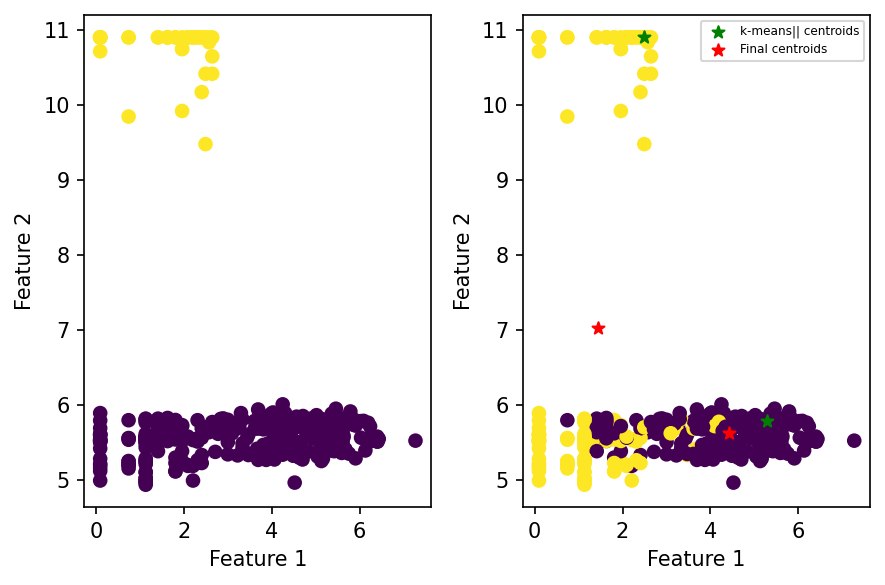

In [64]:
data=make_da(KDD_data)
labels=make_da(KDD_labels)
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,0], data[:,1], c=labels)
ax[1].scatter(data[:,0], data[:,1], c=pred_labels)
ax[1].scatter(centroids_pp_w[:,0], centroids_pp_w[:,1], marker = '*', c='green', label = 'k-means|| centroids')
ax[1].scatter(results[:,0], results[:,1], marker = '*', c='red', label='Final centroids')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
ax[1].legend(loc='upper right', fontsize='xx-small')
plt.tight_layout()
plt.show()

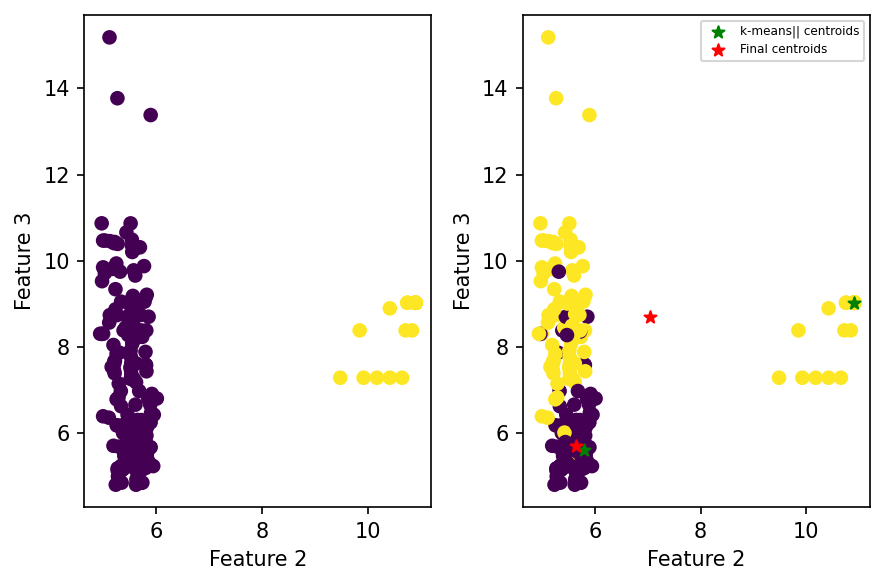

In [65]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,1], data[:,2], c=labels)
ax[1].scatter(data[:,1], data[:,2], c=pred_labels)
ax[1].scatter(centroids_pp_w[:,1], centroids_pp_w[:,2], marker = '*', c='green', label = 'k-means|| centroids')
ax[1].scatter(results[:,1], results[:,2], marker = '*', c='red', label='Final centroids')
ax[0].set_xlabel('Feature 2')
ax[0].set_ylabel('Feature 3')
ax[1].set_xlabel('Feature 2')
ax[1].set_ylabel('Feature 3')
ax[1].legend(loc='upper right', fontsize='xx-small')
plt.tight_layout()
plt.show()

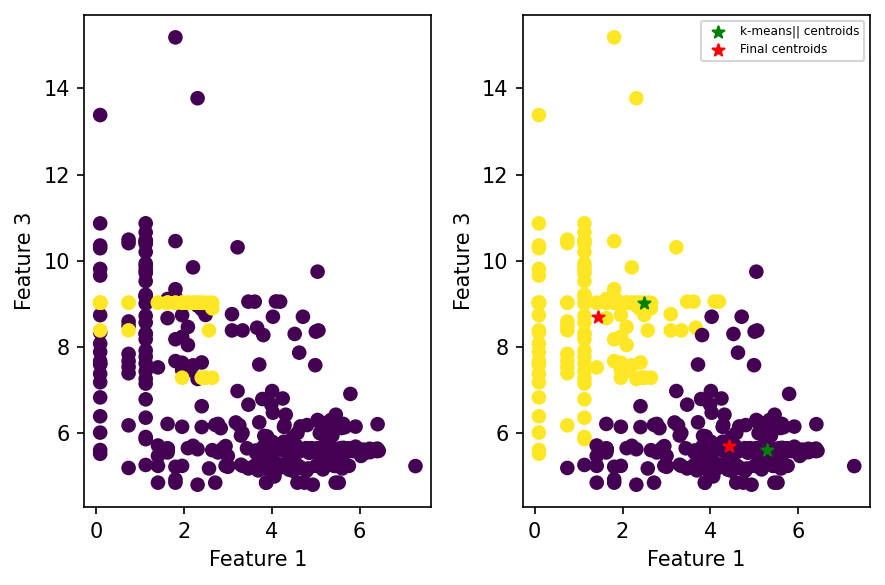

In [66]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,0], data[:,2], c=labels)
ax[1].scatter(data[:,0], data[:,2], c=pred_labels)
ax[1].scatter(centroids_pp_w[:,0], centroids_pp_w[:,2], marker = '*', c='green', label = 'k-means|| centroids')
ax[1].scatter(results[:,0], results[:,2], marker = '*', c='red', label='Final centroids')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 3')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 3')
ax[1].legend(loc='upper right', fontsize='xx-small')
plt.tight_layout()
plt.show()

In [69]:
model = dask_ml.cluster.KMeans(n_clusters=2)
model.fit(KDD_data)
dask_pred_labels=model.predict(KDD_data)

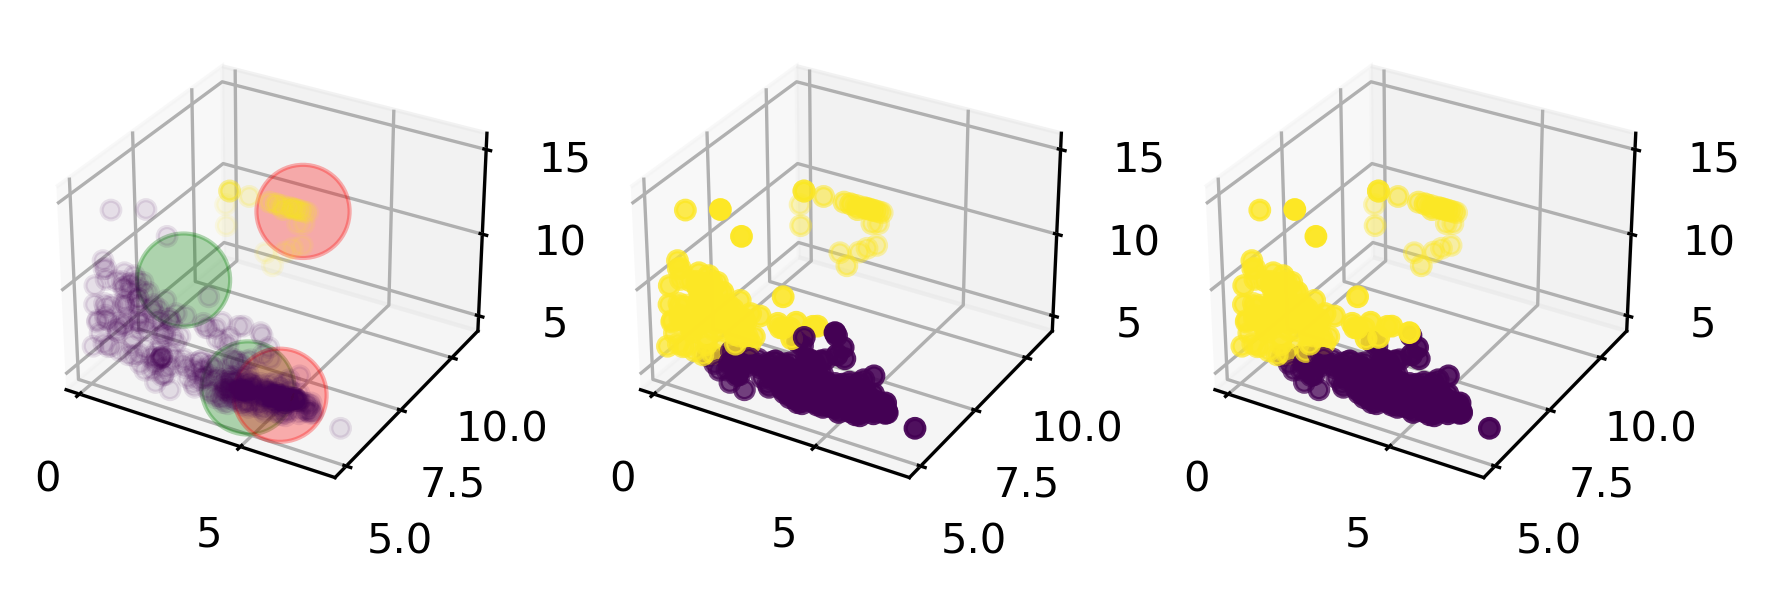

In [103]:
fig = plt.figure(dpi=300, figsize=(7, 7))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(centroids_pp_w[:,0], centroids_pp_w[:,1], centroids_pp_w[:,2], s=50, c='red', alpha=0.3)
ax.scatter(results[:,0], results[:,1], results[:,2], c='green', s=50,  alpha=0.3)
ax.scatter(data[:,0], data[:,1], data[:,2], c=labels, alpha=0.1)
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=pred_labels)
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=dask_pred_labels)
plt.show()

## 3d make blob example

In [110]:
X, y = dask_ml.datasets.make_blobs(10000, n_features=3 ,centers=5, chunks=8)
X = X.rechunk(get_chunks(X))
X.persist()

dask.array<rechunk-merge, shape=(10000, 3), dtype=float64, chunksize=(1250, 3), chunktype=numpy.ndarray>

### KMeans || and ++ initzalisation

In [111]:
%time centroids_pp_w = k_means_scalable(X, k=5, l=2)

CPU times: user 54.9 s, sys: 540 ms, total: 55.4 s
Wall time: 2min 44s


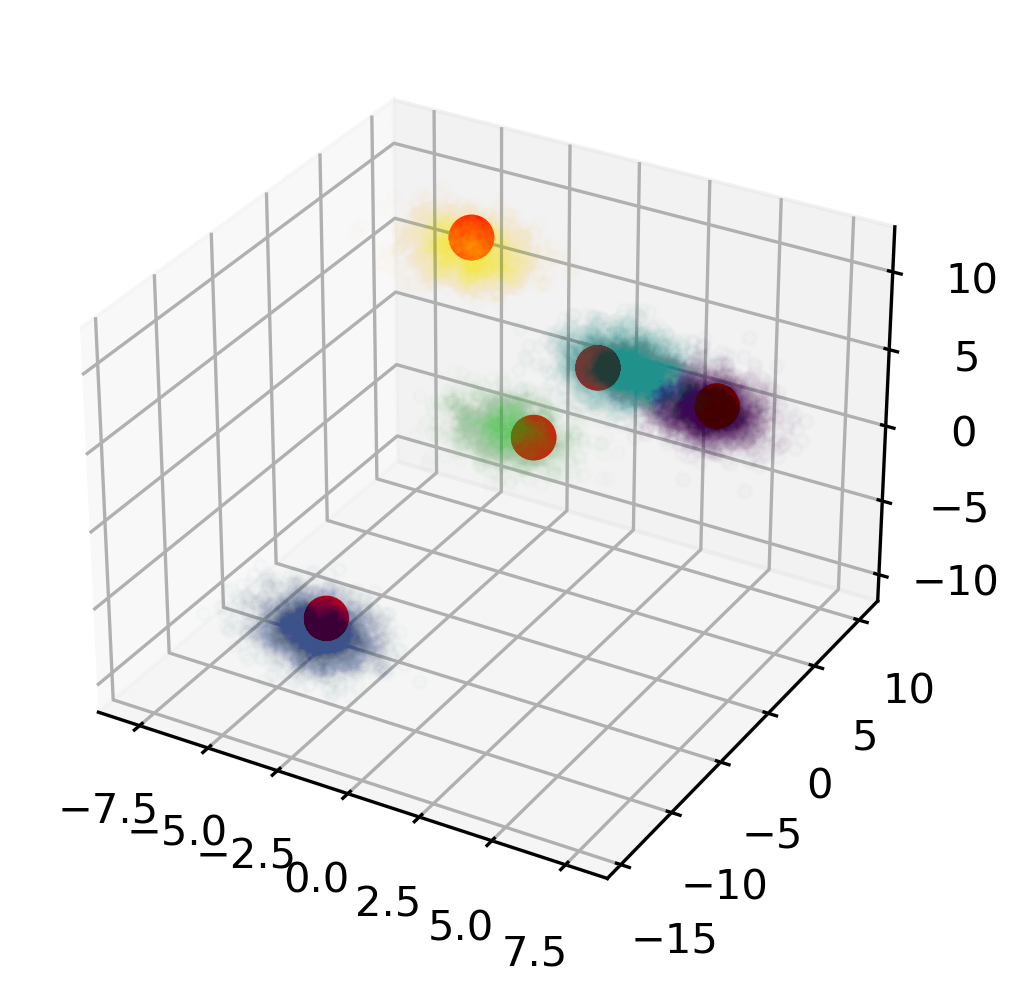

In [115]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=0.01, c=y, s=10)
ax.scatter(centroids_pp_w[:,0], centroids_pp_w[:,1], centroids_pp_w[:,2], s=50, alpha=1, c='red')

### LLoyds 

In [119]:
%time results, pred_labels = da.compute(*lloyd_scalable(X, k=5, centroids = centroids_pp_w, maxIter=30))

CPU times: user 2min 20s, sys: 1.03 s, total: 2min 21s
Wall time: 9min 17s


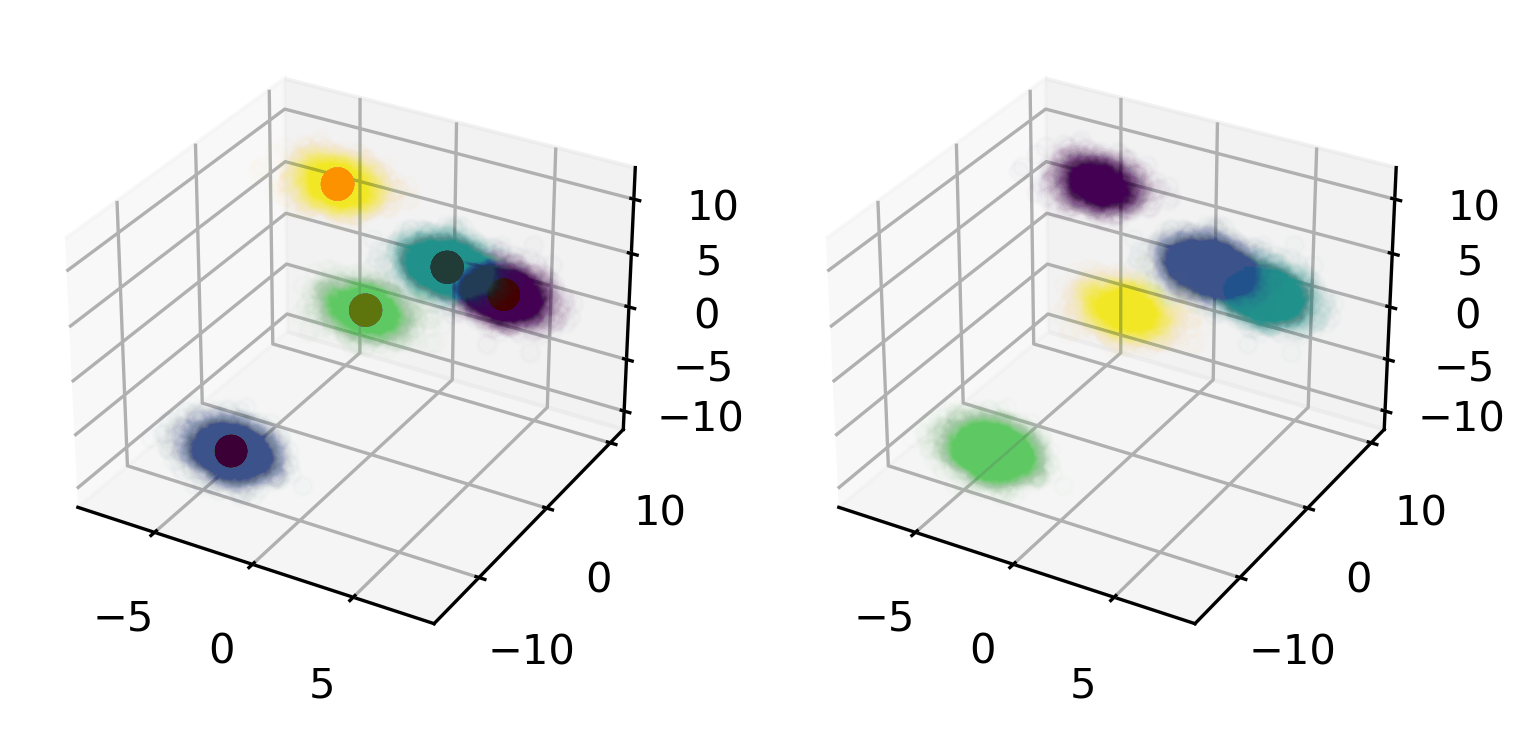

In [121]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(results[:,0], results[:,1], results[:,2], c='red', s=50,  alpha=1)
ax.scatter(X[:,0], X[:,1], X[:,2], c=y, alpha=0.01, s=20)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=pred_labels, alpha=0.01, s=20)

# TV News Channel Commercial Detection Dataset Data Set
### Data Set Information:

Automatic identification of commercial blocks in news videos finds a lot of applications in the domain of television broadcast analysis and monitoring. Commercials occupy almost 40-60% of total air time. Manual segmentation of commercials from thousands of TV news channels is time consuming, and economically infeasible hence prompts the need for machine learning based Method. Classifying TV News commercials is a semantic video classification problem. TV News commercials on particular news channel are combinations of video shots uniquely characterized by audio-visual presentation. Hence various audio visual features extracted from video shots are widely used for TV commercial classification. Indian News channels do not follow any particular news presentation format, have large variability and dynamic nature presenting a challenging machine learning problem. Features from 150 Hours of broadcast news videos from 5 different ( 3 Indian and 2 International News channels) news channels. Viz. CNNIBN, NDTV 24X7, TIMESNOW, BBC and CNN are presented in this dataset. Videos are recorded at resolution of 720 X 576 at 25 fps using a DVR and set top box. 3 Indian channels are recorded concurrently while 2 International are recorded together. Feature file preserves the order of occurrence of shots.

Labels : - +1/-1 ( Commercials/Non Commercials)

Motion Distribution( Mean and Variance) 

2 - 3 

Frame Difference Distribution ( Mean and Variance) 

4 - 5 

Short time energy ( Mean and Variance) 

6 - 7 

ZCR( Mean and Variance) 

8 - 9 

Spectral Centroid ( Mean and Variance) 

10 - 11 

Spectral Roll off ( Mean and Variance) 

12 - 13 

Spectral Flux ( Mean and Variance) 

14 - 15 

Fundamental Frequency ( Mean and Variance) 

16 - 17 

Motion Distribution ( 40 bins) 

18 - 58 

Frame Difference Distribution ( 32 bins) 

59 - 91 

Text area distribution ( 15 bins Mean and 15 bins for variance ) 

92 - 122 

Bag of Audio Words ( 4000 bins) 

123 - 4123 

Edge change Ratio ( Mean and Variance) 

4124 - 4125 

In [23]:
import os
path='./Datasets/TIMESNOW_Cleaned.csv'
file_stats = os.stat(path)
print(f'File Size in Bytes is {file_stats.st_size}')
print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')
n_worker=len(client.scheduler_info()['workers'])

File Size in Bytes is 10782693
File Size in MegaBytes is 10.283177375793457


In [36]:
df=dd.read_csv(path, blocksize=int(file_stats.st_size/n_worker)).drop(columns='Unnamed: 0').persist()
tvlabel= df['Label'].map(lambda x: int((x+1)/2)).copy()
tvdata=df.drop(columns='Label').copy()


### Running K-means

In [25]:
%time centroids_pp_w = k_means_scalable(tvdata, k=2, l=2)

CPU times: user 8.93 s, sys: 127 ms, total: 9.06 s
Wall time: 7min 7s


In [27]:
%time results, pred_labels = da.compute(*lloyd_scalable(tvdata, k=2, centroids = centroids_pp_w, maxIter=30))

CPU times: user 7.55 s, sys: 148 ms, total: 7.7 s
Wall time: 1min 21s


Accuracy

In [42]:
real_label=tvlabel.to_dask_array().compute()
acc=skl.metrics.accuracy_score(real_label, pred_labels)
print(max(acc, 1-acc))

0.6470753082645471


### PCA

In [50]:
data_to_transform=tvdata.to_dask_array(lengths=True)
from dask_ml.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_to_transform)
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  

[0.56125006 0.34398069]


In [53]:
decomposed_data=pca.transform(data_to_transform)

In [55]:
%time centroids_pp_w = k_means_scalable(decomposed_data, k=2, l=2)

CPU times: user 10.6 s, sys: 268 ms, total: 10.8 s
Wall time: 6min 39s


In [56]:
%time results, pred_labels = da.compute(*lloyd_scalable(decomposed_data, k=2, centroids = centroids_pp_w, maxIter=30))

CPU times: user 8.89 s, sys: 187 ms, total: 9.07 s
Wall time: 1min 41s


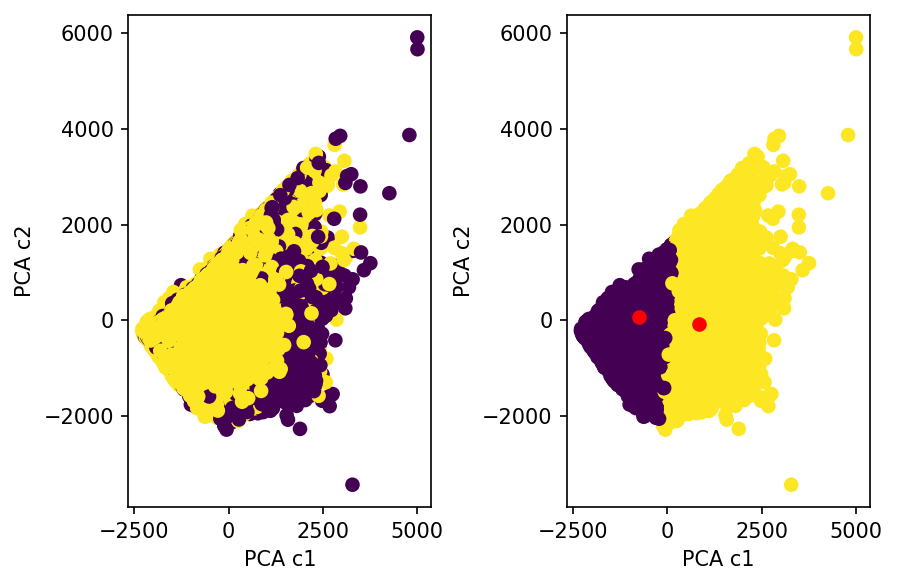

In [59]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(decomposed_data[:,0], decomposed_data[:,1], c=real_label)
ax[1].scatter(decomposed_data[:,0], decomposed_data[:,1], c=pred_labels)
ax[1].scatter(results[:,0], results[:,1],c='red')
ax[0].set_xlabel('PCA c1')
ax[0].set_ylabel('PCA c2')
ax[1].set_xlabel('PCA c1')
ax[1].set_ylabel('PCA c2')
plt.tight_layout()
plt.show()

In [58]:
acc=skl.metrics.accuracy_score(real_label, pred_labels)
print(max(acc, 1-acc))

0.6471007846733925
